In [42]:
import pandas as pd
pd.options.plotting.backend = "plotly"
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
from IPython.display import SVG, display


### Load the sampled version of the dataset (25 742 songs)

In [46]:
df = pd.read_csv("./data/lyrics.csv")
df = df.rename(columns={df.columns[0]: 'id'})
df = df.rename(columns={df.columns[3]: 'title'})
print('Data rows number: ', len(df))
df.head()

Data rows number:  25742


,id,link,artist,title,lyrics
0,0,../lyrics/backstreetboys/climbingthewalls.html,Backstreet Boys Lyrics,Climbing The Walls,"\n\n[Brian:]\nClose your eyes, make a wish\nTh..."
1,1,../lyrics/westlife/howtobreakaheart.html,Westlife Lyrics,How To Break A Heart,\n\r\nSince you're not worth my love\nI haven'...
2,2,../lyrics/deanmartin/iwill.html,Dean Martin Lyrics,I Will,\n\r\nI don't want to be the one to say I'm go...
3,3,../lyrics/deanmartin/tellyourmotherhello.html,Dean Martin Lyrics,Tell Your Mother Hello,\n\r\nSure I loved the dear money that shines ...
4,4,../lyrics/deanmartin/behonestwithme.html,Dean Martin Lyrics,Be Honest With Me,\n\r\nBe honest with me dear whatever you do\n...


### Drop useless columns and keep only english songs

In [47]:
# drop rows containing NaN values
df = df.dropna()
# drop useless columns
df = df.drop(['link'], axis=1)
print('Data rows number: ', len(df))
df.head()

Data rows number:  25742


,id,artist,title,lyrics
0,0,Backstreet Boys Lyrics,Climbing The Walls,"\n\n[Brian:]\nClose your eyes, make a wish\nTh..."
1,1,Westlife Lyrics,How To Break A Heart,\n\r\nSince you're not worth my love\nI haven'...
2,2,Dean Martin Lyrics,I Will,\n\r\nI don't want to be the one to say I'm go...
3,3,Dean Martin Lyrics,Tell Your Mother Hello,\n\r\nSure I loved the dear money that shines ...
4,4,Dean Martin Lyrics,Be Honest With Me,\n\r\nBe honest with me dear whatever you do\n...


### Dataset preprocessing

In [48]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('punkt',quiet=True)
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)

stop_words = stopwords.words('english')
new_stop_words = ['ooh','yeah','hey','whoa','woah', 'ohh', 'was', 'mmm', 'oooh','yah','yeh','mmm', 'hmm','deh','doh','jah']
stop_words.extend(new_stop_words)


def preprocess_text(text):
    # remove \n and words containing '
    text = text.replace('\n', ' ')
    text = re.sub(r'\b\w*\'\w*\b', '', text)
    # remove punctuation
    text = re.sub(r'[,\.!?]', '', text)
    #removing text in square braquet
    text = re.sub(r'\[.*?\]', ' ', text)
    #removing numbers
    text = re.sub(r'\w*\d\w*',' ', text)
    #removing bracket
    text = re.sub(r'[()]', ' ', text)
    #removing underscore at the beginning or at the end of the word
    text = re.sub(r'^_|_$', '', text)
    #removing multiple spaces (merge > 2 spaces in one space)
    text = re.sub(r' {2,}', ' ', text)
    # convert all words in lower case
    text = text.lower()
    # tokenize
    tokens = word_tokenize(text)
    # remove stop words
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # lemmatize
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    #remove tokens with lenght < 3
    final_tokens = [token for token in lemmatized_tokens if len(token) > 2]

    return ' '.join(final_tokens)

cleaned_text = df["lyrics"].apply(preprocess_text)
df["lyrics_proc"] = cleaned_text
df = df.dropna()
df.head()

,id,artist,title,lyrics,lyrics_proc
0,0,Backstreet Boys Lyrics,Climbing The Walls,"\n\n[Brian:]\nClose your eyes, make a wish\nTh...",close eye make wish could last forever could s...
1,1,Westlife Lyrics,How To Break A Heart,\n\r\nSince you're not worth my love\nI haven'...,since worth love given stronger stronger thoug...
2,2,Dean Martin Lyrics,I Will,\n\r\nI don't want to be the one to say I'm go...,want one say gon miss want say gon cry eye bab...
3,3,Dean Martin Lyrics,Tell Your Mother Hello,\n\r\nSure I loved the dear money that shines ...,sure loved dear money shine hair brow furrowed...
4,4,Dean Martin Lyrics,Be Honest With Me,\n\r\nBe honest with me dear whatever you do\n...,honest dear whatever remember mine dear always...


In [52]:
df.to_csv("./data/lyrics_proc.csv", header='true', index=False)

### Analysis

#### Top-10 most common words in the entire corpus

In [ ]:
from collections import Counter
all_words = ' '.join(df['lyrics_proc']).split()

# Count the frequency of each word
word_counts = Counter(all_words)

# Get the 10 most common words
most_common_10 = word_counts.most_common(10)

# Display the results
print("The 10 most frequent words are:")
for word, count in most_common_10:
    print(f"{word}: {count}")

The 10 most frequent words are:
love: 53174
know: 52158
like: 50855
got: 45900
get: 35518
baby: 29645
one: 25432
time: 25367
never: 23411
say: 22818


#### Artists

In [ ]:
# Calculate the value counts
df['artist'] = df['artist'].str.replace(' Lyrics', '', regex=False)
artist_counts = df['artist'].value_counts()

# Create the bar chart
fig_artist = go.Figure(data=[
    go.Bar(
        x=artist_counts.index,
        y=artist_counts.values,
        marker_color='rgb(148, 103, 189)'  # Change the color
    )
])

# Update layout
fig_artist.update_layout(
    title=dict(
        text='<b>Count of Artists</b><br>',
        font=dict(size=20)
    ),
    width=700,
    height=500,
    xaxis=dict(title='Artist'),
    yaxis=dict(title='Count'),
    template='ggplot2'  # Applying the ggplot2 template
)

# Show plot
fig_artist.show('svg')

# Save plot
pio.write_image(fig_artist, './plots/count_artist.pdf')


#### Lyrics length

In [55]:
# Get lyric frequencies for each song
df['lyrics_num_tks'] = df['lyrics_proc'].map(lambda x: len(x.split()))

# Create a dictionary to store lyrics length by artist
lyric_count_dict = {artist: df[df['artist'] == artist]['lyrics_num_tks'].tolist() for artist in df['artist'].unique()}

# Create box plot traces for each artist
traces = []
for artist, counts in lyric_count_dict.items():
    traces.append(go.Box(
        y=counts,
        name=artist,
        marker_color='rgb(148, 103, 189)'  # Change the color
    ))

# Create the figure
fig_dist = go.Figure(data=traces)

# Update layout
fig_dist.update_layout(
    title=dict(
        text='<b>Distribution of lyrics length by artist</b><br>',
        font=dict(size=20)
    ),
    margin=dict(l=25, r=25, b=50, t=50, pad=0),
    width=700,
    height=500,
    xaxis=dict(
        title_text='Artist'
    ),
    yaxis=dict(
        title_text='Song lyrics length (n tokens)'
    ),
    template='ggplot2',  # Applying the ggplot2 template
    showlegend=False  # Remove the legend
)

# Show plot
fig_dist.show('svg')

# Save plot
pio.write_image(fig_dist, './plots/lyrics_length.pdf')

#### POS tagging

In [ ]:
import spacy

#load spacy model
nlp = spacy.load('en_core_web_sm')

def pos(tks,pos):

    """Returns any token that qualifies as a specific part of speech"""
    doc = nlp(tks) #fit model

    return ' '.join(list(set([i.text for i in doc if i.pos_ == pos]))) #return any tokens that qualify

#get nouns
df['nouns'] = df.lyrics_proc.map(lambda x: pos(x,'NOUN'))

#get verbs
df['verbs'] = df.lyrics_proc.map(lambda x: pos(x,'VERB'))

#get adjectives
df['adjectives'] = df.lyrics_proc.map(lambda x: pos(x,'ADJ'))

#get adverbs
df['adverbs'] = df.lyrics_proc.map(lambda x: pos(x,'ADV'))

In [ ]:
df.iloc[:5,-4:]

,nouns,verbs,adjectives,adverbs
0,pain way reason eye life illusion skin wan wal...,last kept tell get coming caught got stay caus...,miss close real,forever inside together ohhhh
1,pain love world dream end spinnin break moment...,gave left taking break given learned take tear...,worth enough stronger bad fast past right,stronger away back never slowly still
2,love eye thrill thing wonder baby know,love gone remember find running used told smil...,ashamed dear thrill sad,forever home really much back still
3,shine brow care finger mother dough money hair,keep hold loved wrinkled tell kissed furrowed ...,dear,sure
4,dream return sea memory kinda darling yearn da...,love remember break forget make wander,sweet honest true untrue asleep awake dear poor,really always alone ever never


#### Common words

(-0.5, 1599.5, 799.5, -0.5)

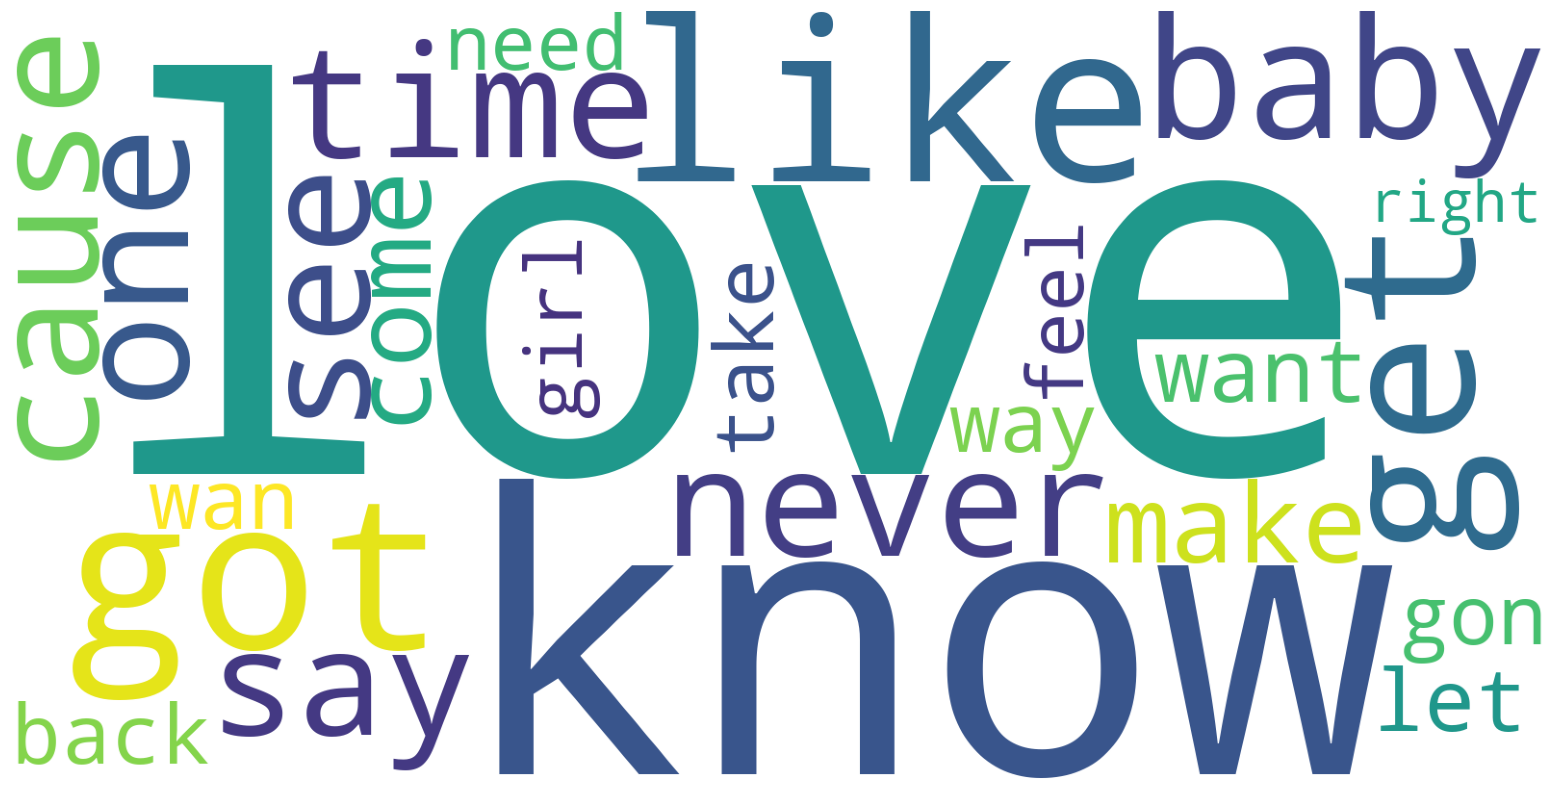

In [54]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def mostcommonTokens(data,token=1):

    """Returns a DataFrame of the most common n (arg)tokens in a string. Excludes stop words. Additional
    stop words can be added"""

    #instantiate count vectorizer and specify tokens
    vect = CountVectorizer(stop_words=new_stop_words, ngram_range= (token,token))

    #fit vectorizer
    X = vect.fit_transform(data)

    #get word counts as DataFrame
    word_counts = pd.DataFrame(np.asarray(X.sum(axis=0))[0],vect.get_feature_names_out(),columns=['count'])

    #sort by count
    word_counts = word_counts.sort_values(by='count', ascending=False)

    return word_counts #return DataFrame
N = 25
top_tks = mostcommonTokens(df.lyrics_proc,token=1).head(N)
wordcloud = WordCloud(background_color='white', width = 1600, height = 800,collocations=False,random_state=100,stopwords=stopwords.words('english')).generate_from_frequencies(top_tks['count'].to_dict())
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('./plots/word_cloud.pdf')

#### Common words tagged as name by artist

In [56]:
def genius_artistmap(df,pos,n=100):

    """Visualisation function. Returns a treemap of the most common n tokens that qualify as a part of speech
    Requires the mostcommonTokens function"""

    #list to populate subset DataFrame's
    all_df = []

    #loop through unique artists
    for i in df.artist.unique():

        #get most common tokens for part of speech
        temp_df = mostcommonTokens(df[df['artist'] == i][pos]).head(n)

        #add column for current artist
        temp_df['artist'] = i

        #append DataFrame to list
        all_df.append(temp_df)

    #concatenate all DataFrame's
    all_df = pd.concat([i for i in all_df])

    #reset index
    all_df.reset_index(drop=False,inplace=True)

    #column labels
    all_df.columns = ['word','count','artist']

    # in order to have a single root node add 'all artists'
    all_df["all artists"] = "all artists"

    #create plotly treemap figure
    fig = px.treemap(all_df, path=['all artists', 'artist', 'word'], values='count',)

    #title parameters
    title_param = dict(text='<b>Most Common Nouns, by artist</b><br>spaCy used for classifying PoS</b>',
                        font=dict(size=20))

    #update layout
    fig.update_layout(title=title_param,
                    font= dict(family='Helvetica',size=14),
                    width=900,
                    height=900,
                    autosize=False,
                    margin=dict(l=40,r=40,b=85,t=100,pad=0,))

    #show plot
    fig.show('svg')

    # Save plot
    pio.write_image(fig, './plots/artist_map.pdf')
    return fig

noun_treemap = genius_artistmap(df,pos='nouns')

KeyError: 'nouns'